### And welcome to Week 4, Day 3 - more LangGraph..

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict
from simple_agent import chatopenai

In [2]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris is the capital city of France and a cultural and culinary hub. In 2024 it played host to its third Olympic Games. Paris, situated on the river Seine ... Paris, the capital of France, is often referred to as the "City o

### Now here is a LangChain wrapper class for converting functions into Tools

In [4]:
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )



### Now we can try out the tool the langchain way

In [5]:
tool_search.invoke("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Paris is the capital city of France and a cultural and culinary hub. In 2024 it played host to its 

### And now let's write a tool ourselves

We'll pick a familiar one

In [6]:
# pushover_token = os.getenv("PUSHOVER_TOKEN")
# pushover_user = os.getenv("PUSHOVER_USER")
# pushover_url = "https://api.pushover.net/1/messages.json"

# def push(text: str):
#     """Send a push notification to the user"""
#     requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [7]:
# tool_push = Tool(
#         name="send_push_notification",
#         func=push,
#         description="useful for when you want to send a push notification"
#     )

# tool_push.invoke("Hello, me")

### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [5]:
# tools = [tool_search, tool_push]
tools = [tool_search]

In [6]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [10]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [11]:
# This is different:

llm = chatopenai(model="deepseek-chat")
llm_with_tools = llm.bind_tools(tools)

In [12]:
# Step 3: Create a Node


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [13]:
# Step 4: Create Edges


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

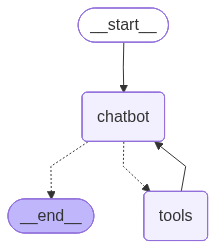

In [14]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [15]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    print(result)
    return result["messages"][-1].content


demo = gr.ChatInterface(chat, type="messages")

In [ ]:
demo.launch()

{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='a7cbb21e-ccd6-42ce-ad8c-d4279ab621f6'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 314, 'total_tokens': 323, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}, 'prompt_cache_hit_tokens': 256, 'prompt_cache_miss_tokens': 58}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'a77d6050-ccf9-437f-a4cb-586cfd251f28', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--8a5ee5ac-2c72-4090-a6e9-bd5e9b424312-0', usage_metadata={'input_tokens': 314, 'output_tokens': 9, 'total_tokens': 323, 'input_token_details': {'cache_read': 256}, 'output_token_details': {}})]}
{'messages': [HumanMessage(content='my name is faze', additional_kwargs={}, response_metadata={}, 

In [17]:
demo.close()

Closing server running on port: 7860


## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [18]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

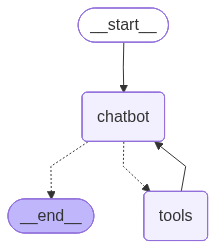

In [19]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = chatopenai(model="deepseek-chat")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    print(result)
    print('-'*20)
    return result["messages"][-1].content


demo2 = gr.ChatInterface(chat, type="messages")

In [ ]:
demo2.launch()

{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='37248e82-6300-462a-9502-cbd24f53a9e4')]}
{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='37248e82-6300-462a-9502-cbd24f53a9e4'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 314, 'total_tokens': 323, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}, 'prompt_cache_hit_tokens': 256, 'prompt_cache_miss_tokens': 58}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '8479c1a8-f761-4eb1-b9db-d14fb824cf70', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--ece03d7f-494e-4406-a687-b6f56bd944b1-0', usage_metadata={'input_tokens': 314, 'output_tokens': 9, 'total_tokens': 323, 'input_token_details': {'cache_read': 25

In [22]:
demo2.close()

Closing server running on port: 7860


In [23]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='37248e82-6300-462a-9502-cbd24f53a9e4'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 314, 'total_tokens': 323, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}, 'prompt_cache_hit_tokens': 256, 'prompt_cache_miss_tokens': 58}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '8479c1a8-f761-4eb1-b9db-d14fb824cf70', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--ece03d7f-494e-4406-a687-b6f56bd944b1-0', usage_metadata={'input_tokens': 314, 'output_tokens': 9, 'total_tokens': 323, 'input_token_details': {'cache_read': 256}, 'output_token_details': {}}), HumanMessage(content='my name is faze', additional_kwargs={}, response_metadat

In [24]:
# Most recent first

list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='37248e82-6300-462a-9502-cbd24f53a9e4'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 314, 'total_tokens': 323, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}, 'prompt_cache_hit_tokens': 256, 'prompt_cache_miss_tokens': 58}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '8479c1a8-f761-4eb1-b9db-d14fb824cf70', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--ece03d7f-494e-4406-a687-b6f56bd944b1-0', usage_metadata={'input_tokens': 314, 'output_tokens': 9, 'total_tokens': 323, 'input_token_details': {'cache_read': 256}, 'output_token_details': {}}), HumanMessage(content='my name is faze', additional_kwargs={}, response_metada

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [7]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

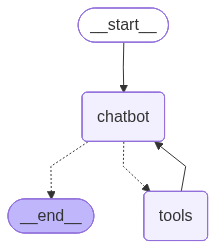

In [8]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = chatopenai(model="deepseek-chat")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [9]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


demo3 = gr.ChatInterface(chat, type="messages")

In [ ]:
demo3.launch()

{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='5cc80248-47da-4d72-b5dd-d4129b11b57b'), AIMessage(content="Hello! How can I help you today? I'm here to assist you with any questions or tasks you might have.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 314, 'total_tokens': 338, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}, 'prompt_cache_hit_tokens': 256, 'prompt_cache_miss_tokens': 58}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '987f6c92-f5f2-4033-a6b2-0263025e04b9', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--c5f66932-7f1d-4ca0-9afe-a56271dc5ef5-0', usage_metadata={'input_tokens': 314, 'output_tokens': 24, 'total_tokens': 338, 'input_token_details': {'cache_read': 256}, 'output_token_details': {}}), HumanMessage(content='my name 

In [11]:
demo3.close()

Closing server running on port: 7860
